# Large Scale Single Cell Electrophysiology & Behavior

In [1]:
# This will ensure that the AllenSDK is installed.
# If not, it will install it for you.
try:
    import allensdk
    print('allensdk already installed.')
except ImportError as e:
    !pip install allensdk

allensdk already installed.


In [2]:
# Import necessary packages 
import numpy as np 
import pandas as pd 
import scipy as sp
import seaborn as sns
from scipy import signal
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Import the Neuropixels Cache
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_project_api import EcephysProjectWarehouseApi
from allensdk.brain_observatory.ecephys.ecephys_project_api.rma_engine import RmaEngine

# Import packages necessary to plot behavior
import allensdk.brain_observatory.ecephys.visualization as ecvis
from allensdk.brain_observatory.visualization import plot_running_speed

# Assign where neuropixels data and 2-photon data will be stored
manifest_path = 'manifest.json' 


# Create the EcephysProjectCache object
cache = EcephysProjectCache(manifest=manifest_path,
                            fetch_api=EcephysProjectWarehouseApi(RmaEngine(scheme="http",host="api.brain-map.org",timeout= 50 * 60)))          

# Download our session data 
session = cache.get_session_data(721123822)
print('Session downloaded.')

Session downloaded.


## Units

Now that we have downloaded the single session file, we can begin to explore our `EcephysSession` object. The `units` property of our session object returns a dataframe that contains the recorded activity of sorted neurons from a mouse brain. There are many metrics stored within `units` that can be used in your potential analyses. Some key metrics include:

- **firing rate**: mean spike rate during the entire session
- **presence ratio**: fraction of session when spikes are present
- **ISI violations**: rate of refractory period violations
- **peak_channel_id**: channel in which peak-to-trough amplitutde is maximized
- **d'**: classification accuracy based on LDA
- **SNR**: signal to noise ratio
- **Maximum drift**: Maximum change in spike depth during recording
- **Cumulative drift**: Cumulative change in spike depth during recording

For a full list of methods and attributes that can be called on an `EcephysSession` object, please see <a href = 'https://allensdk.readthedocs.io/en/v1.7.1/allensdk.brain_observatory.ecephys.ecephys_session.html'> here</a>.

In [3]:
# Return units dataframe
units_df = session.units
units_df.head()

,amplitude_cutoff,firing_rate,presence_ratio,snr,waveform_velocity_below,isolation_distance,silhouette_score,waveform_velocity_above,nn_miss_rate,waveform_PT_ratio,...,ecephys_structure_id,ecephys_structure_acronym,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,probe_description,location,probe_sampling_rate,probe_lfp_sampling_rate,probe_has_lfp_data
unit_id,,,,,,,,,,,,,,,,,,,,,
950907205,0.012123,14.739577,0.99,2.838052,NaN,129.172458,0.193312,-0.892797,0.004831,1.054721,...,313.0,MB,8456.0,3144.0,6920.0,probeA,See electrode locations,29999.970785,1249.998783,True
950907524,0.002313,1.448536,0.99,4.285082,0.686767,50.450187,0.143138,0.068677,0.001834,0.558508,...,313.0,MB,8447.0,3127.0,6924.0,probeA,See electrode locations,29999.970785,1249.998783,True
950907209,0.084063,0.040263,0.96,3.343694,0.000000,19.926951,NaN,0.156975,0.000467,0.637890,...,313.0,MB,8447.0,3127.0,6924.0,probeA,See electrode locations,29999.970785,1249.998783,True
950907526,0.024568,0.376838,0.99,2.697075,0.000000,66.773857,0.092951,0.595198,0.000235,0.576049,...,313.0,MB,8433.0,3102.0,6929.0,probeA,See electrode locations,29999.970785,1249.998783,True
950907216,0.002750,8.277175,0.99,2.387977,-0.343384,89.982684,0.120142,-0.480737,0.001606,0.651440,...,313.0,MB,8419.0,3077.0,6934.0,probeA,See electrode locations,29999.970785,1249.998783,True


To ensure that the recordings we use in our analysis are all of good quality, we will filter the data according to the signal-to-noise ratio (`snr`) and the `ISI_Violations` of our neurons. Below we will plot the distributions of both.

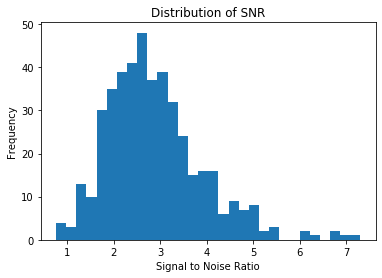

In [4]:
# Signal to noise distribution
col_1 = 'snr'
plt.hist(units_df['snr'], bins=30)
plt.title('Distribution of SNR')
plt.xlabel('Signal to Noise Ratio')
plt.ylabel('Frequency')
plt.show()

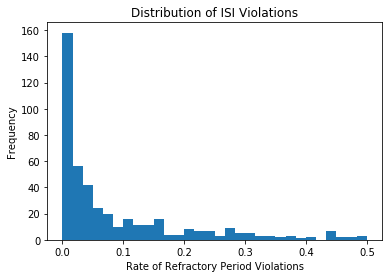

In [5]:
# ISI distribution 
col_2 = 'isi_violations'
plt.hist(units_df[col_2], bins=30)
plt.title('Distribution of ISI Violations')
plt.xlabel('Rate of Refractory Period Violations')
plt.ylabel('Frequency')
plt.show()

For the purposes of this tutorial, we will use `snr` values greater than 2 and `ISI_violation` values less than 0.1, define our good quality units. 

In [6]:
# Create dataframe with our conditions of interest
good_snr = units_df[units_df['snr']>2]
good_units_df = good_snr[good_snr['isi_violations']<0.1]


print('Number of Recordings with good SNR and Low ISI:')
print(len(good_units_df))
good_units_df.head()

Number of Recordings with good SNR and Low ISI:
252


,amplitude_cutoff,firing_rate,presence_ratio,snr,waveform_velocity_below,isolation_distance,silhouette_score,waveform_velocity_above,nn_miss_rate,waveform_PT_ratio,...,ecephys_structure_id,ecephys_structure_acronym,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,probe_description,location,probe_sampling_rate,probe_lfp_sampling_rate,probe_has_lfp_data
unit_id,,,,,,,,,,,,,,,,,,,,,
950907205,0.012123,14.739577,0.99,2.838052,NaN,129.172458,0.193312,-0.892797,0.004831,1.054721,...,313.0,MB,8456.0,3144.0,6920.0,probeA,See electrode locations,29999.970785,1249.998783,True
950907524,0.002313,1.448536,0.99,4.285082,0.686767,50.450187,0.143138,0.068677,0.001834,0.558508,...,313.0,MB,8447.0,3127.0,6924.0,probeA,See electrode locations,29999.970785,1249.998783,True
950907209,0.084063,0.040263,0.96,3.343694,0.000000,19.926951,NaN,0.156975,0.000467,0.637890,...,313.0,MB,8447.0,3127.0,6924.0,probeA,See electrode locations,29999.970785,1249.998783,True
950907526,0.024568,0.376838,0.99,2.697075,0.000000,66.773857,0.092951,0.595198,0.000235,0.576049,...,313.0,MB,8433.0,3102.0,6929.0,probeA,See electrode locations,29999.970785,1249.998783,True
950907216,0.002750,8.277175,0.99,2.387977,-0.343384,89.982684,0.120142,-0.480737,0.001606,0.651440,...,313.0,MB,8419.0,3077.0,6934.0,probeA,See electrode locations,29999.970785,1249.998783,True


Just like we did before in our sessions dataframe, we can return the brain structures that our session's data was recorded from as well as how many neurons were recorded per brain area. 

In [7]:
col = 'ecephys_structure_acronym'

print('Available Brain Structures:')
print(good_units_df[col].unique())
print('\n Brain Structure Frequency:')
print(good_units_df[col].value_counts())

Available Brain Structures:
['MB' 'SCig' 'DG' 'CA1' 'VISam' 'LP' 'VIS' 'VISp' 'LGv' 'CA3' 'VISl' 'APN'
 'POL' 'VISal' 'VISrl']

 Brain Structure Frequency:
CA1      42
LP       38
VISrl    28
VISal    25
DG       23
VISam    16
VISl     16
VIS      15
VISp     14
APN       8
SCig      8
CA3       6
LGv       5
MB        5
POL       3
Name: ecephys_structure_acronym, dtype: int64


## Firing Rate 

In our dataframe, the mean spike rates for each unit can be found under the `firing_rate` column. Let, look at the distibution of firing rates across all brain areas using a violinplot. 

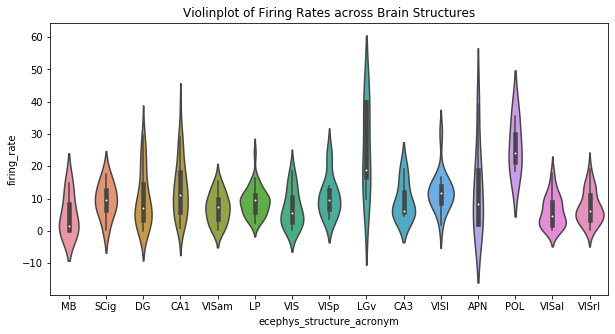

In [8]:
plt.figure(figsize = (10,5))
sns.violinplot(y='firing_rate', x='ecephys_structure_acronym',data = good_units_df)
plt.title('Violinplot of Firing Rates across Brain Structures')
plt.show()

## Waveforms 

Each session contains a dictionary of mean waveforms for all the units recorded in that session. They are stored inside a xarray DataArray where the `unit_id` are mapped to the mean spike waveform values. The dimensions of the DataArrays are `channel` and `time` which are recorded in microvolts and seconds, respectivley. For more information on `xarray.DataArray`, please visit, <a href = 'http://xarray.pydata.org/en/stable/generated/xarray.DataArray.html'> here</a>.

To access the mean spike waveforms for all units in a session, use the attribute `mean_waveforms` on your `EcephysSession` object. 

In [9]:
all_mean_waveforms = session.mean_waveforms
print('Total number of waveforms:')
print(len(all_mean_waveforms))

Total number of waveforms:
444


We can plot the mean waveforms of our units with the method `plot_mean_waveforms` from the ecephys visualization package. The method uses the `mean_waveforms` dictionary, `unit_id`'s, and `peak_channel_id`'s as arguments. For more information on this method, visit <a href = 'https://allensdk.readthedocs.io/en/latest/allensdk.brain_observatory.ecephys.visualization.html'> here</a>.

Below we will compare mean waveforms from different brain areas. We will be looking at one wavefrom from the `CA1`, `LP`, `DG`, `VISp`. We first need to create a list of unit_id's for the waveforms we are interested in. 

In [10]:
# Assign Unit IDs of different brain areas of interest
CA1_unit_ids = good_units_df[good_units_df['ecephys_structure_acronym'] == 'CA1'].index
LP_unit_ids = good_units_df[good_units_df['ecephys_structure_acronym'] == 'LP'].index
DG_unit_ids = good_units_df[good_units_df['ecephys_structure_acronym'] == 'DG'].index
VISp_unit_ids = good_units_df[good_units_df['ecephys_structure_acronym'] == 'VISp'].index

# Return first entry of our brain areas of interst
first_CA1_units_ids = CA1_unit_ids[0]
first_LP_units_ids = LP_unit_ids[0]
first_DG_units_ids = DG_unit_ids[1]
first_VISp_units_ids = VISp_unit_ids[0]
uois_ids = [first_CA1_units_ids, first_LP_units_ids, first_DG_units_ids, first_VISp_units_ids]

# Return dataframe
uois_df = good_units_df.loc[uois_ids]

uois_df

,amplitude_cutoff,firing_rate,presence_ratio,snr,waveform_velocity_below,isolation_distance,silhouette_score,waveform_velocity_above,nn_miss_rate,waveform_PT_ratio,...,ecephys_structure_id,ecephys_structure_acronym,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,probe_description,location,probe_sampling_rate,probe_lfp_sampling_rate,probe_has_lfp_data
unit_id,,,,,,,,,,,,,,,,,,,,,
950907546,0.000854,4.082628,0.99,3.943883,-0.274707,58.423581,0.069653,0.000000,0.005875,0.244961,...,382.0,CA1,7698.0,1633.0,7510.0,probeA,See electrode locations,29999.970785,1249.998783,True
950907603,0.006899,9.856607,0.99,2.898651,NaN,46.240011,0.138128,0.686767,0.003605,0.638382,...,218.0,LP,7468.0,3236.0,7499.0,probeB,See electrode locations,29999.923119,1249.996797,True
950907719,0.000141,19.238828,0.99,4.111892,-0.686767,116.666580,0.231334,-0.343384,0.000000,0.502406,...,726.0,DG,7567.0,2175.0,7376.0,probeB,See electrode locations,29999.923119,1249.996797,True
950908410,0.000492,21.928571,0.99,2.340180,-0.156975,113.004473,-0.057741,0.206030,0.009693,0.734521,...,385.0,VISp,8570.0,1364.0,8024.0,probeC,See electrode locations,29999.999795,1249.999991,True


Using the `unit_ids`, we can create our own dictionary that maps our ids of interest to the `mean_waveforms` array,

unit_id
950907546     CA1
950907603      LP
950907719      DG
950908410    VISp
Name: ecephys_structure_acronym, dtype: object


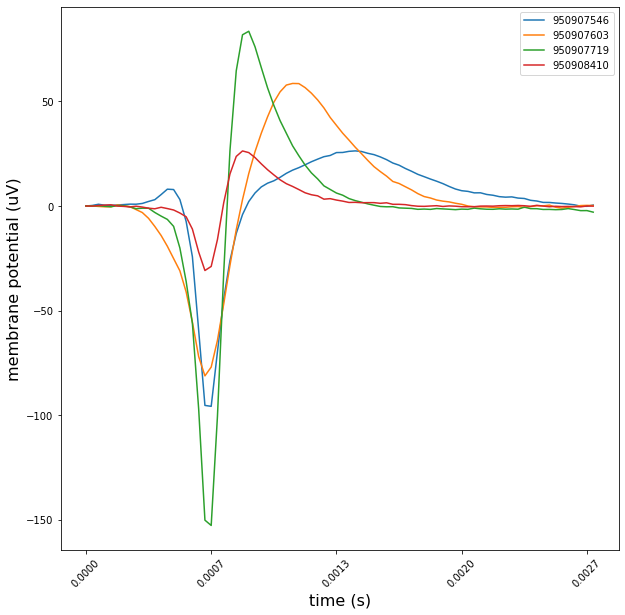

In [11]:
# Create dictionary of waveforms that only include units of interest
waveforms_oi = {}
for ids in uois_ids:
    waveforms_oi[ids] = all_mean_waveforms[ids]

# Create dictionary of peak channels that only include units of interest
peak_channels_oi = {}
for ids in uois_ids:
    peak_channels_oi[ids] = good_units_df.loc[ids, 'peak_channel_id']

# Plot mean waveforms
fig = ecvis.plot_mean_waveforms(waveforms_oi, uois_ids, peak_channels_oi)

print(uois_df['ecephys_structure_acronym'] )

plt.show()

## Stimulus Presentations

The spike data can be sorted according to the type of stimulus that was presented to the mouse. You can access the different stimuli that were presented in the session by using the attribute `stimulus_names`. Each stimulus contains a set of parameters that were used when presented to the mouse. For example two gabors stimuli may be presented, but they may have differing temporal frequencies or different x and y positions. 

Ececuting the `stimulus_presentations` method on our session object will return a pandas dataframe with parameters for each stimulus as the columns which we can use to compare the resoponses of units to different stimulus presentations. 

In [12]:
# Stimulus presentation dataframe 
stim_pres = session.stimulus_presentations

# Stimuli presented in session
all_stims = session.stimulus_names

# Continous timeblocks where only 1 type of stimulus was presented
# Could maybe use this w/ running speed
stim_timeblocks = session.get_stimulus_epochs()


all_stims

['spontaneous',
 'gabors',
 'flashes',
 'drifting_gratings',
 'natural_movie_three',
 'natural_movie_one',
 'static_gratings',
 'natural_scenes']

In [13]:
stim_pres.head()

,color,contrast,frame,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,x_position,y_position,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,,,,,
0,null,null,null,null,null,null,null,26.219072,null,spontaneous,86.285852,null,null,null,60.066780,0
1,null,0.8,null,45.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,86.285852,0.0,gabors,86.519369,4.0,-10.0,-20.0,0.233517,1
2,null,0.8,null,45.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,86.519369,0.0,gabors,86.769565,4.0,-40.0,-30.0,0.250196,2
3,null,0.8,null,90.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,86.769565,0.0,gabors,87.019762,4.0,-10.0,-10.0,0.250196,3
4,null,0.8,null,0.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,87.019762,0.0,gabors,87.269958,4.0,20.0,-10.0,0.250196,4


In [14]:
stim_timeblocks.head()

,start_time,stop_time,duration,stimulus_name,stimulus_block
0,26.219072,86.285852,60.066780,spontaneous,null
1,86.285852,998.280652,911.994800,gabors,0.0
2,998.280652,1287.272022,288.991370,spontaneous,null
3,1287.272022,1585.771259,298.499237,flashes,1.0
4,1585.771259,1587.522722,1.751463,spontaneous,null


Alternatively, you could use the `get_stimulus_table()` method to return a subset of stimulus presentation by `stimulus_name`. Below we will investigate how our neuronal units responded to a `flashes` stimulus presentations.

In [15]:
flashes_df = session.get_stimulus_table(['flashes'])
flashes_df.head()

,color,contrast,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,
3647,1.0,0.8,0.0,"[0.0, 0.0]","[300.0, 300.0]","[0.0, 0.0]",1287.272022,1.0,flashes,1287.522219,0.250197,244
3648,1.0,0.8,0.0,"[0.0, 0.0]","[300.0, 300.0]","[0.0, 0.0]",1289.273682,1.0,flashes,1289.523884,0.250202,244
3649,-1.0,0.8,0.0,"[0.0, 0.0]","[300.0, 300.0]","[0.0, 0.0]",1291.275322,1.0,flashes,1291.525529,0.250207,245
3650,-1.0,0.8,0.0,"[0.0, 0.0]","[300.0, 300.0]","[0.0, 0.0]",1293.276962,1.0,flashes,1293.527179,0.250217,245
3651,1.0,0.8,0.0,"[0.0, 0.0]","[300.0, 300.0]","[0.0, 0.0]",1295.278712,1.0,flashes,1295.528906,0.250194,244


Our goal will be to plot the spike trains of a unit according to the `stimulus_presentation_id` that were presented. We can use `presentationwise_spike_counts` to build an array of spike counts. We will need to specify the `bin_edges` and `stimulus_presentation_ids` to execute this method. The duration of a presented stimulus is roughly 0.25 seconds, so we will create time bins of 0.01 seconds. 

In [16]:
# Assign the duration of a presented stimulus
first_flashes_id = flashes_df.index[0]
first_flashes_duration = flashes_df.loc[first_flashes_id, 'duration']

# Create bins for our timestamps
time_step = 1/100
timestamps = np.arange(0.0, (first_flashes_duration + time_step), time_step)

timestamps

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26])

In [17]:
# Build your array of spike counts
flashes_histogram = session.presentationwise_spike_counts(
    bin_edges = timestamps,
    stimulus_presentation_ids = flashes_df.index,
    unit_ids = None)

flashes_histogram

<xarray.DataArray 'spike_counts' (stimulus_presentation_id: 150, time_relative_to_stimulus_onset: 26, unit_id: 444)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]]], dtype=uint16)
Coordinates:
  * stimulus_presentation_id         (stimulus_presentation_id) int64 3647 ... 3796
  * time_relative_to_stimulus_onset  (time_relative_to_stimulus_onset) float64 0.005 ... 0.255
  * unit_id                          (unit_id) int64 950907205 ... 950913839

We have created our time bins and built our array of spike counts and are ready to plot our neuorns' reponses to stimulus presentations. As you can see, `flashes_histogram` is not a normal array, it is an `xarray.DataArray` which we have not see before. An `xarray.DataArray` can be thought of as a NumPy array with labled axes and indices. An `xarray.DataArray` contains dimensions, which tell you what each axes in the array is, and coordiates which label each dimension. For more information on `xarray.DataArray` objects, please visit <a href = 'http://xarray.pydata.org/en/stable/generated/xarray.DataArray.html'> here</a>.

Below we plot the spike trains of the first unit in `flashes_histogram` for the first 10 `stimulus_presentation_ids`.

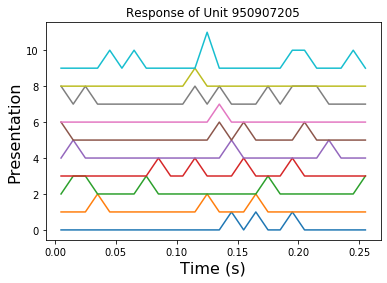

In [18]:
# Plot the first unit's response to the first 10 presentations of flashes
for i in range(10):   
    plt.plot(flashes_histogram.time_relative_to_stimulus_onset, i+flashes_histogram[i,:,0])
plt.xlabel("Time (s)", fontsize=16)
plt.ylabel("Presentation", fontsize=16)
plt.title("Response of Unit 950907205")
plt.show()

We can also plot the mean number of spikes of all the units across all presentations. Below we will take the mean of all spike counts for presentations of the flashes `stimulus_name`. We willl be using `xrplot` to plot our heatmap of mean spike counts. For information on how to use `xrplot`, please visit <a href = 'http://xarray.pydata.org/en/stable/plotting.html'> here</a>.

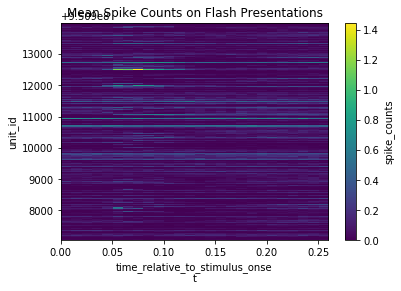

In [19]:
# Assign the mean spike times of all units' responses to flashes presentations 
mean_flash_histogram = flashes_histogram.mean(dim = 'stimulus_presentation_id')
mean_flash_histogram.coords

import xarray.plot as xrplot
xrplot.imshow(darray=mean_flash_histogram, x="time_relative_to_stimulus_onset",
                                      y="unit_id")
plt.title('Mean Spike Counts on Flash Presentations')
plt.show()

In [20]:
spf = flashes_histogram[0]
max_len = spf.shape[0]

In [21]:
# get two spike trains in flashes activity
spike_train_1_flash=spf[:max_len, 0]
spike_train_2_flash=spf[:max_len, 9]

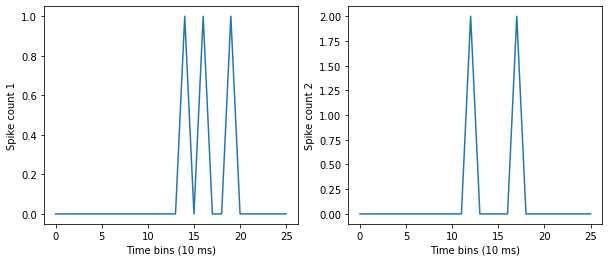

In [22]:
fig, ax = plt.subplots(1, 2,figsize=(10,4))

ax[0].plot(spike_train_1_flash)
ax[0].set_ylabel('Spike count 1')
ax[0].set_xlabel('Time bins (10 ms)')

ax[1].plot(spike_train_2_flash)
ax[1].set_ylabel('Spike count 2')
ax[1].set_xlabel('Time bins (10 ms)')
plt.show()

In [23]:
# compute the correlogram for spontaneous activity
xcorr_flashes = sp.signal.correlate(spike_train_1_flash,spike_train_2_flash)

# time steps
time_shift_flashes = np.arange(-len(xcorr_flashes)/2,len(xcorr_flashes)/2,1)

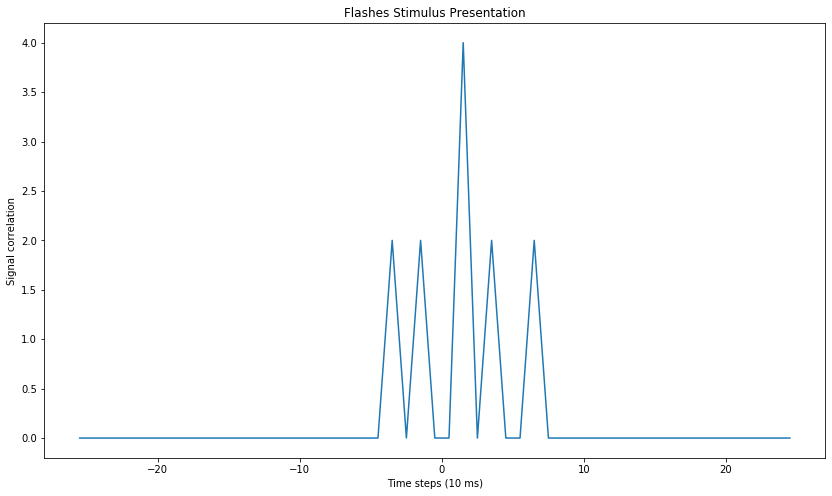

In [24]:
plt.figure(figsize=(14,8))
plt.plot(time_shift_flashes,xcorr_flashes)
plt.ylabel('Signal correlation')
plt.xlabel('Time steps (10 ms)')
plt.title('Flashes Stimulus Presentation')
plt.show()

## Spike Times

Our `EcephysSession` object contains spike time for each unit and they can be accessed via the `spike_times` attribute. With this data, we are able to compare spike times across units and across stimuli by plotting a rasterplot. 

We first need to select a unit to focus on. Below, we will assign the spike times of a unit from the CA1 area. 

In [25]:
# Assign the first CA1 spike times array by subselecting with unit_id
all_spike_times = session.spike_times
first_CA1_spike_times = all_spike_times[first_CA1_units_ids]

# Return length of spike times and values
print('Spikes found for unit ' + str(first_CA1_units_ids) + ': ' + str(len(all_spike_times[first_CA1_units_ids])))

print(first_CA1_spike_times)

Spikes found for unit 950907546: 40053
[9.06566412e+00 9.06896412e+00 1.17636334e+01 ... 9.81044358e+03
 9.81044668e+03 9.81046488e+03]


We can sort the neural spikes according to what stimulus stimulus was presented in the session in order to look for any correlation in nerual activity. The `presentationwise_spike_counts()` method returns an array of spike counts according to the stimulus presented and the onset time. You will need to specify the presentation_ids when calling the method. 

Once we have our spike count array, we can create a rasterplot using `raster_plot()`. For more information on how to use `raster_plot()`, please visit<a href = 'https://allensdk.readthedocs.io/en/latest/allensdk.brain_observatory.ecephys.visualization.html'> here</a>.

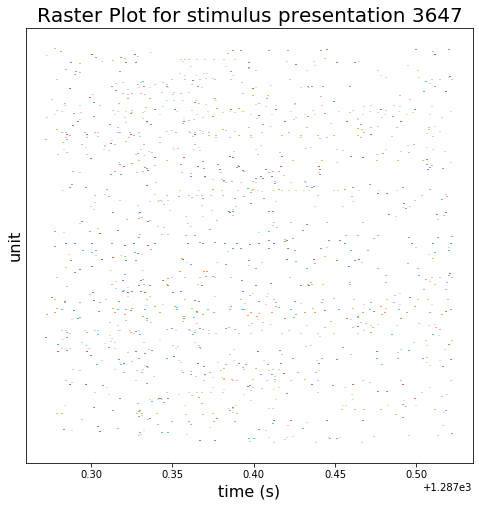

Parameters for presentation 3647


color                               1.0
contrast                            0.8
frame                              null
orientation                         0.0
phase                        [0.0, 0.0]
size                     [300.0, 300.0]
spatial_frequency            [0.0, 0.0]
start_time                  1287.272022
stimulus_block                      1.0
stimulus_name                   flashes
stop_time                   1287.522219
temporal_frequency                 null
x_position                         null
y_position                         null
duration                       0.250197
stimulus_condition_id               244
Name: 3647, dtype: object

In [26]:
# Return presentation ids from stimulus presentation dataframe for 'flashes' stimulus
flashes_presentation_ids = stim_pres.loc[(stim_pres['stimulus_name'] == 'flashes')].index.values


times = session.presentationwise_spike_times(
    stimulus_presentation_ids=flashes_presentation_ids,
    unit_ids= None)

# Assign the stimulus presentation id
first_flashes_presentation_id = times['stimulus_presentation_id'].values[0]

# Assign recording times for 'flashes' stimulus presentations
plot_times = times[times['stimulus_presentation_id'] == first_flashes_presentation_id]

# Assign Raster plot 
ecvis.raster_plot(plot_times, title = 'Raster Plot for stimulus presentation 3647')

plt.show()

print('Parameters for presentation 3647')
stim_pres.loc[first_flashes_presentation_id]

In [27]:
spike_statistics = session.conditionwise_spike_statistics(stimulus_presentation_ids = flashes_presentation_ids,
                                                          unit_ids = None)

spike_statistics.head()

,,spike_count,stimulus_presentation_count,spike_mean,spike_std,spike_sem
unit_id,stimulus_condition_id,,,,,
950907205,244,253,75,3.373333,1.991694,0.229981
950907216,244,123,75,1.640000,1.401158,0.161792
950907220,244,1000,75,13.333333,4.647968,0.536701
950907222,244,9,75,0.120000,0.366134,0.042278
950907225,244,112,75,1.493333,1.234343,0.142530


## Running Speeds